# Date Converter

We will be translating from one date format to another. In order to do this we need to connect two set of LSTMs (RNNs). The diagram looks as follows: Each set respectively sharing weights (i.e. each of the 4 green cells have the same weights and similarly with the blue cells). The first is a many to one LSTM, which summarises the question at the last hidden layer (and cell memory).

The second set (blue) is a Many to Many LSTM which has different weights to the first set of LSTMs. The input is simply the answer sentence while the output is the same sentence shifted by one. Ofcourse during testing time there are no inputs for the `answer` and is only used during training.
![seq2seq_diagram](https://i.stack.imgur.com/YjlBt.png) 

**20th January 2017 => 20th January 2009**
![troll](./images/troll_face.png)

## References:
1. Plotting Tensorflow graph: https://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter/38192374#38192374
2. The generation process was taken from: https://github.com/datalogue/keras-attention/blob/master/data/generate.py
3. 2014 paper with 2000+ citations: https://arxiv.org/pdf/1409.3215.pdf

In [1]:
!pip install faker babel

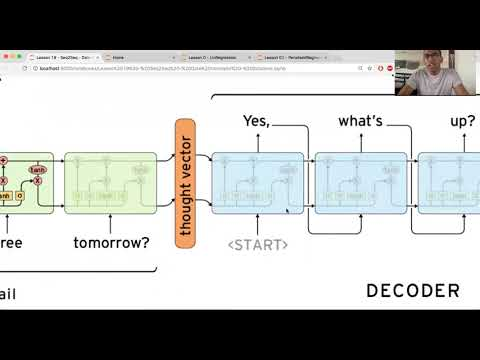

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo("_Sm0q_FckM8")

In [7]:
!pip install tqdm

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import random
import json
import os
import time

from faker import Faker
import babel
from babel.dates import format_date

import tensorflow as tf

import tensorflow.contrib.legacy_seq2seq as seq2seq
from utilities import show_graph

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [4]:
fake = Faker()
fake.seed(42)
random.seed(42)

FORMATS = ['short',
           'medium',
           'long',
           'full',
           'd MMM YYY',
           'd MMMM YYY',
           'dd MMM YYY',
           'd MMM, YYY',
           'd MMMM, YYY',
           'dd, MMM YYY',
           'd MM YY',
           'd MMMM YYY',
           'MMMM d YYY',
           'MMMM d, YYY',
           'dd.MM.YY',
           ]

# change this if you want it to work with only a single language
LOCALES = babel.localedata.locale_identifiers()
LOCALES = [lang for lang in LOCALES if 'en' in str(lang)]
LOCALES2 = 

In [5]:
def create_date():
    """
        Creates some fake dates 
        :returns: tuple containing 
                  1. human formatted string
                  2. machine formatted string
                  3. date object.
    """
    dt = fake.date_object()

    # wrapping this in a try catch because
    # the locale 'vo' and format 'full' will fail
    try:
        human = format_date(dt,
                            format=random.choice(FORMATS),
                            locale=random.choice(LOCALES))

        case_change = random.randint(0,3) # 1/2 chance of case change
        if case_change == 1:
            human = human.upper()
        elif case_change == 2:
            human = human.lower()

        machine = dt.isoformat()
    except AttributeError as e:
        return None, None, None

    return human, machine #, dt

data = [create_date() for _ in range(50000)]

See below what we are trying to do in this lesson. We are taking dates of various formats and converting them into a standard date format:

In [6]:
data[:5]

[('7 07 13', '2013-07-07'),
 ('30 JULY 1977', '1977-07-30'),
 ('Tuesday, September 14, 1971', '1971-09-14'),
 ('18 09 88', '1988-09-18'),
 ('31, Aug 1986', '1986-08-31')]

In [6]:
x = [x for x, y in data]
y = [y for x, y in data]

u_characters = set(' '.join(x))
char2numX = dict(zip(u_characters, range(len(u_characters))))

u_characters = set(' '.join(y))
char2numY = dict(zip(u_characters, range(len(u_characters)))) #TODO: complete 

Pad all sequences that are shorter than the max length of the sequence

In [7]:
char2numX['<PAD>'] = len(char2numX)
num2charX = dict(zip(char2numX.values(), char2numX.keys()))
max_len = max([len(date) for date in x])

x = [[char2numX['<PAD>']]*(max_len - len(date)) +[char2numX[x_] for x_ in date] for date in x]
print(''.join([num2charX[x_] for x_ in x[4]]))
x = np.array(x)

<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>31, Aug 1986


In [8]:
char2numY['<GO>'] = len(char2numY)
num2charY = dict(zip(char2numY.values(), char2numY.keys()))

y = [[char2numY['<GO>']] + [char2numY[y_] for y_ in date] for date in y]
print(''.join([num2charY[y_] for y_ in y[4]]))
y = np.array(y)

<GO>1986-08-31


In [9]:
x_seq_length = len(x[0])
y_seq_length = len(y[0])- 1

In [10]:
def batch_data(x, y, batch_size):
    shuffle = np.random.permutation(len(x))
    start = 0
#     from IPython.core.debugger import Tracer; Tracer()()
    x = x[shuffle]
    y = y[shuffle]
    while start + batch_size <= len(x):
        yield x[start:start+batch_size], y[start:start+batch_size]
        start += batch_size

In [11]:
epochs = 2
batch_size = 128
nodes = 32
embed_size = 10

tf.reset_default_graph()
sess = tf.InteractiveSession()

# Tensor where we will feed the data into graph
inputs = tf.placeholder(tf.int32, (None, x_seq_length), 'inputs')
outputs = tf.placeholder(tf.int32, (None, None), 'output')
targets = tf.placeholder(tf.int32, (None, None), 'targets')

# Embedding layers
input_embedding = tf.Variable(tf.random_uniform((len(char2numX), embed_size), -1.0, 1.0), name='enc_embedding')
# TODO: create the variable output embedding
output_embedding = 
# TODO: Use tf.nn.embedding_lookup to complete the next two lines
date_input_embed = tf.nn.embedding_lookup(input_embedding, inputs)
date_output_embed = 

with tf.variable_scope("encoding") as encoding_scope:
    lstm_enc = tf.contrib.rnn.BasicLSTMCell(nodes)
    _, last_state = tf.nn.dynamic_rnn(lstm_enc, inputs=date_input_embed, dtype=tf.float32)

with tf.variable_scope("decoding") as decoding_scope:
    # TODO: create the decoder LSTMs, this is very similar to the above
    # you will need to set initial_state=last_state from the encoder
    lstm_dec = 
    dec_outputs, _ = 
#connect outputs to 
logits = tf.contrib.layers.fully_connected(dec_outputs, num_outputs=len(char2numY), activation_fn=None) 
with tf.name_scope("optimization"):
    # Loss function
    loss = tf.contrib.seq2seq.sequence_loss(logits, targets, tf.ones([batch_size, y_seq_length]))
    # Optimizer
    optimizer = tf.train.RMSPropOptimizer(1e-3).minimize(loss)

In [17]:
dec_outputs.get_shape().as_list()

[None, None, 32]

In [21]:
last_state[0].get_shape().as_list()

[None, 32]

In [23]:
inputs.get_shape().as_list()

[None, 29]

In [24]:
date_input_embed.get_shape().as_list()

[None, 29, 10]

Train the graph above:

In [12]:
show_graph(tf.get_default_graph().as_graph_def())

In [13]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [14]:
sess.run(tf.global_variables_initializer())
epochs = 10
for epoch_i in range(epochs):
    start_time = time.time()
    for batch_i, (source_batch, target_batch) in enumerate(batch_data(X_train, y_train, batch_size)):
        _, batch_loss, batch_logits = sess.run([optimizer, loss, logits],
            feed_dict = {inputs: source_batch,
             outputs: target_batch[:, :-1],
             targets: target_batch[:, 1:]})
    accuracy = np.mean(batch_logits.argmax(axis=-1) == target_batch[:,1:])
    print('Epoch {:3} Loss: {:>6.3f} Accuracy: {:>6.4f} Epoch duration: {:>6.3f}s'.format(epoch_i, batch_loss, 
                                                                      accuracy, time.time() - start_time))

Epoch   0 Loss:  1.281 Accuracy: 0.5523 Epoch duration:  6.781s
Epoch   1 Loss:  0.800 Accuracy: 0.6977 Epoch duration:  7.516s
Epoch   2 Loss:  0.627 Accuracy: 0.7812 Epoch duration:  6.762s
Epoch   3 Loss:  0.541 Accuracy: 0.7898 Epoch duration:  7.199s
Epoch   4 Loss:  0.467 Accuracy: 0.8266 Epoch duration:  6.352s
Epoch   5 Loss:  0.368 Accuracy: 0.8781 Epoch duration:  6.993s
Epoch   6 Loss:  0.318 Accuracy: 0.8938 Epoch duration:  8.078s
Epoch   7 Loss:  0.283 Accuracy: 0.9055 Epoch duration:  7.166s
Epoch   8 Loss:  0.242 Accuracy: 0.9227 Epoch duration:  5.982s
Epoch   9 Loss:  0.241 Accuracy: 0.9055 Epoch duration:  7.145s


Translate on test set

In [15]:
source_batch, target_batch = next(batch_data(X_test, y_test, batch_size))

dec_input = np.zeros((len(source_batch), 1)) + char2numY['<GO>']
for i in range(y_seq_length):
    batch_logits = sess.run(logits,
                feed_dict = {inputs: source_batch,
                 outputs: dec_input})
    prediction = batch_logits[:,-1].argmax(axis=-1)
    dec_input = np.hstack([dec_input, prediction[:,None]])
    
print('Accuracy on test set is: {:>6.3f}'.format(np.mean(dec_input == target_batch)))

Accuracy on test set is:  0.882


Let's randomly take two from this test set and see what it spits out:

In [16]:
num_preds = 10
source_chars = [[num2charX[l] for l in sent if num2charX[l]!="<PAD>"] for sent in source_batch[:num_preds]]
dest_chars = [[num2charY[l] for l in sent] for sent in dec_input[:num_preds, 1:]]

for date_in, date_out in zip(source_chars, dest_chars):
    print(''.join(date_in)+' => '+''.join(date_out))

25 Nov 2008 => 2008-11-25
october 5 1995 => 1995-10-05
